# **Setting**

In [1]:
#Data Processing
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator
import PIL
from google.colab import drive

import warnings
from glob import glob
from PIL import Image

#for model
import torch
import torch.nn as nn
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB0, EfficientNetV2L,ResNet152V2
from tensorflow.keras.layers import Input, Dense, Activation, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [2]:
drive.mount('/content/drive')

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

Mounted at /content/drive


In [39]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2"  # Set the GPU 2 to use, 멀티 gpu

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#GPU 체크 및 할당
if torch.cuda.is_available():
    #device = torch.device("cuda:0")
    print('Device:', device)
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

No GPU available, using the CPU instead.


# **Import Data**

In [4]:
base_path = '/content/drive/MyDrive/Colab Notebooks/DL/2023 Fall_project : Landmark Classification/dataset/'
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DL/2023 Fall_project : Landmark Classification/dataset/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DL/2023 Fall_project : Landmark Classification/dataset/test.csv")

# data directory
train_dir = os.path.join(base_path, 'train/')
test_dir = os.path.join(base_path, 'test/')

,file_name,label
0,001.PNG,9
1,002.PNG,4
2,003.PNG,1
3,004.PNG,1
4,005.PNG,6


,file_name
0,001.PNG
1,002.PNG
2,003.PNG
3,004.PNG
4,005.PNG


723

199

(array([67., 71., 75., 71., 67., 75., 75., 72., 74., 76.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

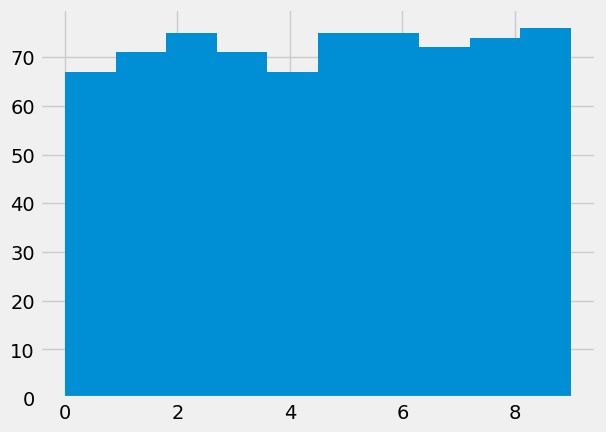

In [29]:
display(train.head(5))
display(test.head(5))
display(len(train))
display(len(test))
plt.hist(train['label'])

In [6]:
train_dir_list = []
test_dir_list = []

# get train dir list
train_dir_list.extend(glob(os.path.join(train_dir+'*.PNG')))
train_dir_list.sort()

# get test dir list
test_dir_list.extend(glob(os.path.join(test_dir+'*.PNG')))
test_dir_list.sort()

print(train_dir_list[:5])
print(test_dir_list[:5])

['/content/drive/MyDrive/Colab Notebooks/DL/2023 Fall_project : Landmark Classification/dataset/train/001.PNG', '/content/drive/MyDrive/Colab Notebooks/DL/2023 Fall_project : Landmark Classification/dataset/train/002.PNG', '/content/drive/MyDrive/Colab Notebooks/DL/2023 Fall_project : Landmark Classification/dataset/train/003.PNG', '/content/drive/MyDrive/Colab Notebooks/DL/2023 Fall_project : Landmark Classification/dataset/train/004.PNG', '/content/drive/MyDrive/Colab Notebooks/DL/2023 Fall_project : Landmark Classification/dataset/train/005.PNG']
['/content/drive/MyDrive/Colab Notebooks/DL/2023 Fall_project : Landmark Classification/dataset/test/001.PNG', '/content/drive/MyDrive/Colab Notebooks/DL/2023 Fall_project : Landmark Classification/dataset/test/002.PNG', '/content/drive/MyDrive/Colab Notebooks/DL/2023 Fall_project : Landmark Classification/dataset/test/003.PNG', '/content/drive/MyDrive/Colab Notebooks/DL/2023 Fall_project : Landmark Classification/dataset/test/004.PNG', '/c

In [7]:
# dataframe transfer
train_df = pd.DataFrame([train_dir_list, train["label"]], index=["dir", "label"]).T
test_df = pd.DataFrame(test_dir_list, columns=["dir"])

display(train_df.head(5))
display(test_df.head(5))

,dir,label
0,/content/drive/MyDrive/Colab Notebooks/DL/2023...,9
1,/content/drive/MyDrive/Colab Notebooks/DL/2023...,4
2,/content/drive/MyDrive/Colab Notebooks/DL/2023...,1
3,/content/drive/MyDrive/Colab Notebooks/DL/2023...,1
4,/content/drive/MyDrive/Colab Notebooks/DL/2023...,6


,dir
0,/content/drive/MyDrive/Colab Notebooks/DL/2023...
1,/content/drive/MyDrive/Colab Notebooks/DL/2023...
2,/content/drive/MyDrive/Colab Notebooks/DL/2023...
3,/content/drive/MyDrive/Colab Notebooks/DL/2023...
4,/content/drive/MyDrive/Colab Notebooks/DL/2023...


# **visualization, Augmentation**
augmentation 통해 데이터 수 늘리고, 500by500으로 reshape

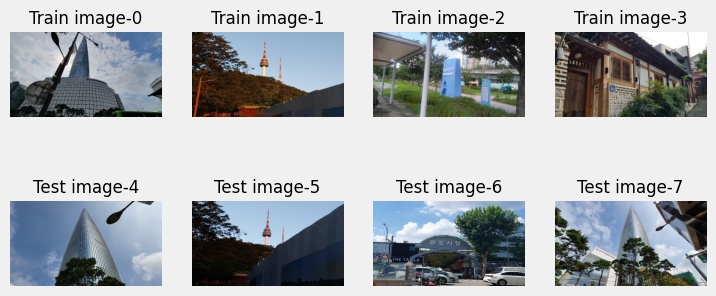

In [8]:
%matplotlib inline

nrows, ncols = 4, 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(nrows*2, ncols*2)

pic_index += 8

next_train_pix = [x for x in train_df['dir'][ pic_index-4:pic_index ]]
next_test_pix = [x for x in test_df['dir'][ pic_index-4:pic_index ]]

for i, img_path in enumerate(next_train_pix + next_test_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    if i <= 3 :
        plt.gca().set_title('Train image-' + str(i), fontsize=12)
    else :
        plt.gca().set_title('Test image-' + str(i), fontsize=12)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [9]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [10]:
train_df['label'] = train_df['label'].astype('str')

# **train/validation split**

In [11]:
train_data = datagen.flow_from_dataframe(
    train_df,
    x_col='dir',
    y_col='label',
    target_size=(500, 500),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training')


valid_data = datagen.flow_from_dataframe(
    train_df,
    x_col='dir',
    y_col='label',
    target_size=(500, 500),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation')

Found 615 validated image filenames belonging to 10 classes.
Found 108 validated image filenames belonging to 10 classes.


augmentation 결과 확인

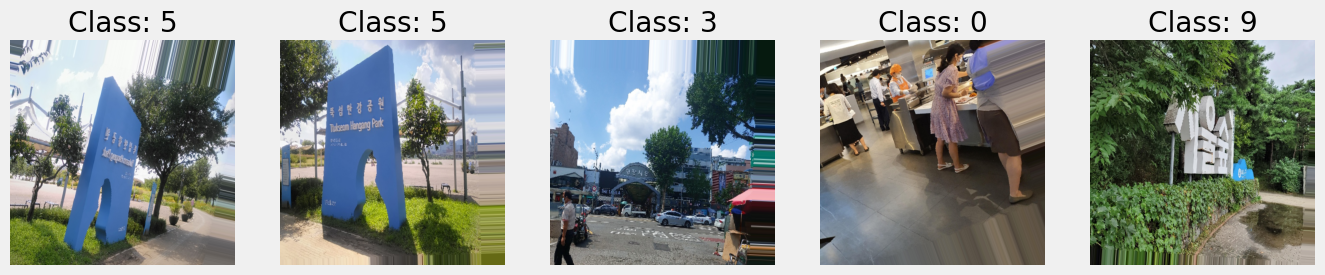

In [43]:
# train_data에서 이미지 배치 가져오기
augmented_images, labels = train_data.next()

# 이미지 시각화 함수
def visualize_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(f'Class: {labels[i].argmax()}')
        axes[i].axis('off')
    plt.show()


visualize_images(augmented_images, labels)

# **modeling**

## **ResNet**

In [12]:
def ResNet_model():
    tf.random.set_seed(2022)
    input_tensor = Input(shape=(500, 500, 3))
    base_model = ResNet152V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    base_model.trainable = False # 재학습 여부

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(10, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)

    return model

In [13]:
# model check & early stopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks = ModelCheckpoint("epoch",
                                   monitor='val_loss')

In [14]:
model = ResNet_model().to(device)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(train_data, epochs=20,
                    batch_size=32,
                    callbacks=[callbacks,early_stopping_callback],
                    validation_data=valid_data)

234545216/234545216 [==============================] - 7s 0us/step
Epoch 1/20
20/20 [==============================] - 594s 29s/step - loss: 1.7418 - acc: 0.4293 - val_loss: 0.6444 - val_acc: 0.9259
Epoch 2/20
20/20 [==============================] - 362s 18s/step - loss: 0.6812 - acc: 0.7984 - val_loss: 0.2463 - val_acc: 0.9352
Epoch 3/20
20/20 [==============================] - 397s 20s/step - loss: 0.3914 - acc: 0.8667 - val_loss: 0.1161 - val_acc: 0.9722
Epoch 4/20
20/20 [==============================] - 361s 18s/step - loss: 0.2774 - acc: 0.9106 - val_loss: 0.0654 - val_acc: 0.9815
Epoch 5/20
20/20 [==============================] - 358s 18s/step - loss: 0.2322 - acc: 0.9285 - val_loss: 0.0649 - val_acc: 0.9907
Epoch 6/20
20/20 [==============================] - 361s 18s/step - loss: 0.2091 - acc: 0.9301 - val_loss: 0.0928 - val_acc: 0.9722
Epoch 7/20
20/20 [==============================] - 363s 18s/step - loss: 0.1430 - acc: 0.9626 - val_loss: 0.0437 - val_acc: 0.9907
Epoch 8/2

# **evaluation**

In [16]:
def show_graph(history_dict):
    accuracy = history_dict['acc']
    val_accuracy = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)


    fig = plt.figure(figsize = (14,2))


    plt.subplot(1,2,1)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'r+', label = 'Training accuracy')
    plt.plot(epochs, val_accuracy, 'r-', label = 'Validation accuracy')
    plt.title('Training and validation accuracy and loss')

    plt.legend(loc = 'best', bbox_to_anchor=(0.5, -0.1),
               fancybox = True, shadow=True, ncol=5)

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b+', label='Training loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.title( 'Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)

    plt.show()

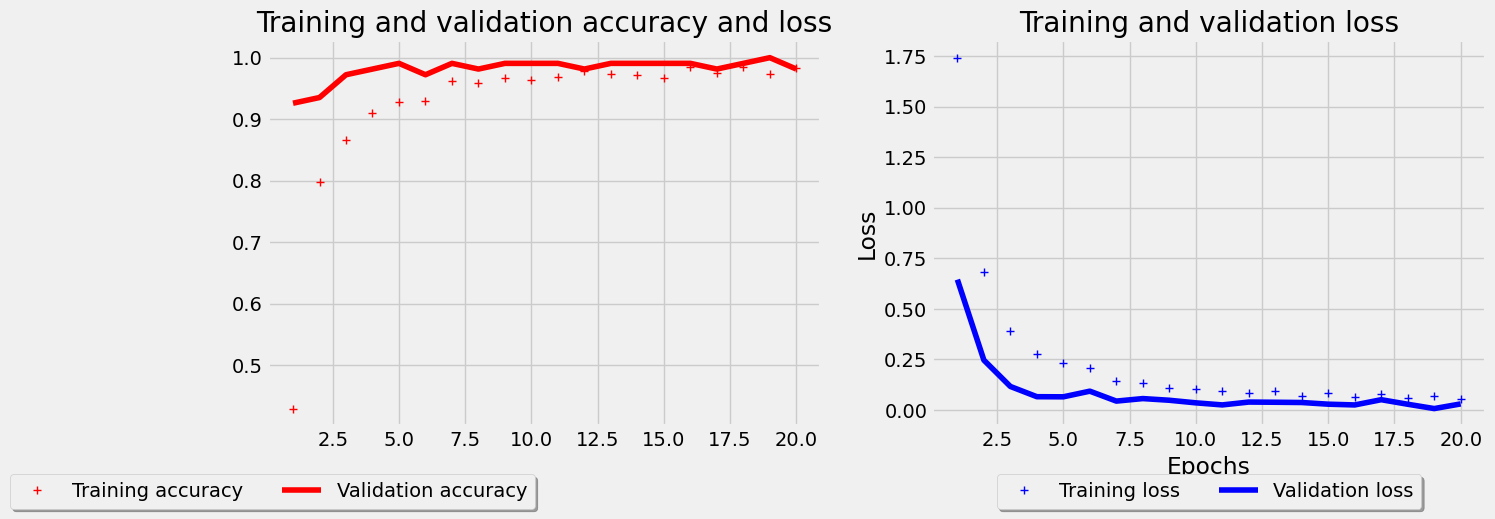

In [17]:
show_graph(history.history)

# **Predict**

In [18]:
test_gen = ImageDataGenerator(
    rescale=1./255)


test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col="dir",
    target_size = (500,500),
    batch_size = 32,
    class_mode=None,
    shuffle=False,
)

Found 199 validated image filenames.


In [19]:
preds = model.predict_generator(test_data)

predict = []
for i in preds:
    predict.append(np.argmax(i))

In [56]:
predict[:5]
test_df['predicted_label'] = predict

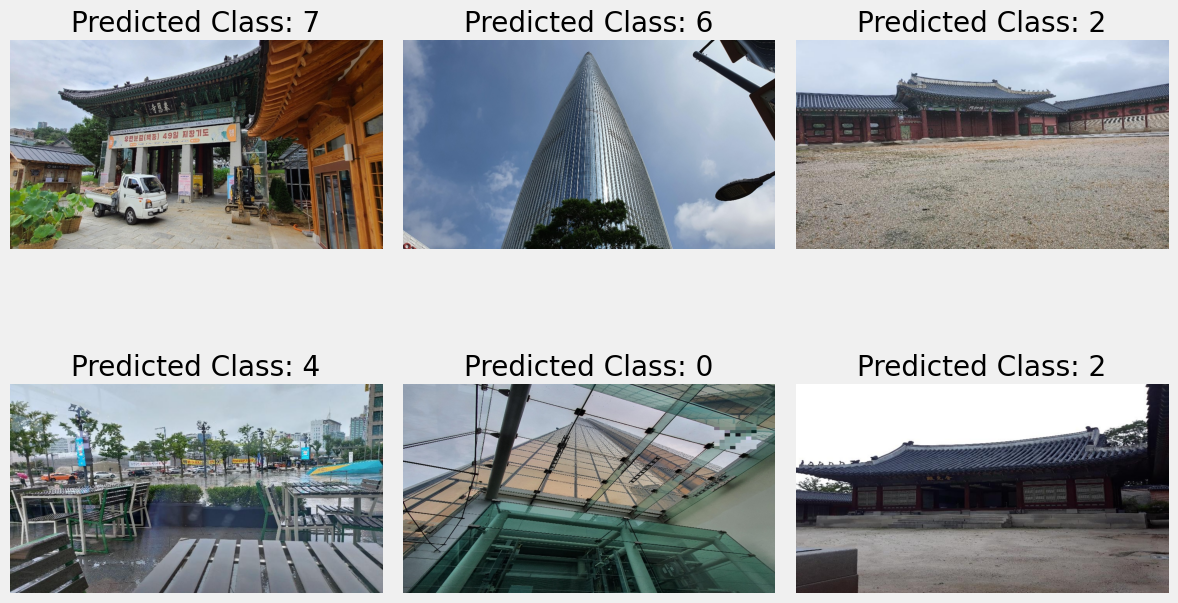

In [61]:
def visualize_predictions(dataframe, num_rows=2, num_cols=3):
    # 데이터프레임에서 무작위로 num_samples 개의 샘플 선택
    samples = dataframe.sample(num_rows * num_cols)

    # 이미지와 예측 결과를 지정된 행과 열에 배열하여 표시
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, ax in enumerate(axes.flatten()):
        # 선택된 샘플
        sample = samples.iloc[i]
        image_path = sample['dir']  # 이미지 경로
        predicted_class = sample['predicted_label']  # 예측된 클래스

        # 이미지 로드
        img = mpimg.imread(image_path)

        # 이미지와 예측된 클래스 시각화
        ax.imshow(img)
        ax.set_title(f'Predicted Class: {predicted_class}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(test_df)

In [22]:
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DL/2023 Fall_project : Landmark Classification/dataset/sample_submission.csv")
submission["label"] = predict

In [23]:
submission['label'].value_counts()

6    23
7    21
8    21
4    21
1    20
0    20
5    20
3    19
9    17
2    17
Name: label, dtype: int64

In [25]:
submission.to_csv("/content/drive/MyDrive/Colab Notebooks/DL/2023 Fall_project : Landmark Classification/dataset/ResNet152V2_submission_ex.csv", index=False)